# Stabiliser Simulations of Measurement Only Dynamics and Condensation in $\mathbb{Z}_2$-Toric Code

### Some Useful Definitions

In [9]:
using Base.Filesystem  # for creaating directories etc
using ArgParse
using Random, Distributions  # random numbers
using HDF5  # hdf5 files
using QuantumClifford  # this is the stabilizer simulation package
using Plots # for plotting
using Formatting # string formatting


# define enum just for just for better readibility of code
@enum PauliType begin
    PauliX = 1
    PauliY = 2    
    PauliZ = 3
end

@enum TermType begin
    Star = 1
    Plaq = 2    
       e = 3
       m = 4
       f = 5 
end

In [10]:
function bit_string_i(i::Integer, n::Integer)
    """returns a bitstring (array of bool) of size n, that is false anywhere but at position i.
       This is convenient since paulis in the QuantumClifford package are defined by two bitstrings"""
    str = zeros(Bool, n);
    str[i] = true;
    return str
end


function bit_string_ij(i::Integer, j::Integer, n::Integer)
    """returns a bitstring (array of bool) of size n, that is false anywhere but at position i and j.
       This is convenient since paulis in the QuantumClifford package are defined by two bitstrings"""
    @assert(i != j);
    str = zeros(Bool, n);
    str[i] = true;
    str[j] = true;
    return str
end


function bit_string_ijkl(i::Integer, j::Integer, k::Integer, l::Integer, n::Integer)
    """returns a bitstring (array of bool) of size n, that is false anywhere but at positions i, j, k, and l.
       This is convenient since paulis in the QuantumClifford package are defined by two bitstrings"""
    @assert(i != j);
    @assert(i != k);
    @assert(i != l);
    @assert(j != k);
    @assert(j != l);
    @assert(k != l);
   
    str = zeros(Bool, n);
    str[i] = true;
    str[j] = true;
    str[k] = true;
    str[l] = true;
    
    return str
end

bit_string_ijkl (generic function with 1 method)

In [11]:
function pauli1_i(t::PauliType, i::Integer, n::Integer)
    """returns a one-body-pauli of given type, acting on positions i in a n-qubit system"""
    bits = bit_string_i(i, n);

    if t == PauliX::PauliType
        return PauliOperator(0x0, bits, zeros(Bool, n));
    elseif t == PauliZ::PauliType 
        return PauliOperator(0x0, zeros(Bool, n), bits); 
    else
        return PauliOperator(0x0, bits, bits);
    end
end


function pauli2_ij(t::PauliType, i::Integer, j::Integer, n::Integer)
    """returns a two-body-pauli of given type, acting on positions i and j in a n-qubit system"""
    bits = bit_string_ij(i, j, n);

    if t == PauliX::PauliType
        return PauliOperator(0x0, bits, zeros(Bool, n));
    elseif t == PauliZ::PauliType 
        return PauliOperator(0x0, zeros(Bool, n), bits); 
    else
        return PauliOperator(0x0, bits, bits);
    end
end


function pauli4_ijkl(t::PauliType, i::Integer, j::Integer, k::Integer, l::Integer, n::Integer)
    """returns a four-body-pauli of given type, acting on positions i and j in a n-qubit system"""
    bits = bit_string_ijkl(i, j, k, l,  n);

    if t == PauliX::PauliType
        return PauliOperator(0x0, bits, zeros(Bool, n));
    elseif t == PauliZ::PauliType 
        return PauliOperator(0x0, zeros(Bool, n), bits); 
    else
        return PauliOperator(0x0, bits, bits);
    end
end

pauli4_ijkl (generic function with 1 method)

## Purification Transition Code

### Full Entropy Measurement Code (for Purification)

In [12]:
function run_measurement_only_dynamics!(state::MixedDestabilizer,
                                       get_random_pauli::Function,
                                       nt::Integer,
                                       measure_ts::AbstractArray)
    """this runs the mesaurement only dynamics. 
       state            : state to be evolved. It is taken by reference (hence the ! in the name by convention).
       get_random_pauli : a function that is called each time step and should generate the paulis to be measured.
       nt               : the total number of time steps (one time step is defined as number-of-sites measurements
       measure_ts       : times at which entropy is measured)
       """
    
    # get system size n (number of qubits)
    n = size(stabilizerview(state))[2]
    # this will store the total entropy (con Neumann) as a function of time
    entropies = Vector{Float64}([entanglement_entropy(state, 1:n, Val(:clip))])
    
    # now perform nt measurement sweeps
    for t in 1:nt
        for tt in 1:n
            # projectrand randomizes also the measurement outcomes
            projectrand!(state,             # state to measure
                         get_random_pauli() # the model is fully defined by this function
                         )
        end
        if t > measure_ts[length(entropies)]
            # calculate the full van-neumann entropy of the system
            s = entanglement_entropy(state,     # state to compute entropy for
                                     1:n,       # subsystem as list of indices. Specifying full subsystem gives the van-neumann entropy
                                     Val(:clip) # algorithm to use (see documentation)
                                     )
            push!(entropies, s)
        end
    end
    
    return entropies 
end

run_measurement_only_dynamics! (generic function with 1 method)

### Model Definition

For the start let us just do the Toric Code.

In [13]:
function random_TC_condenser_Pauli(L, term_type_dist::DiscreteNonParametric)
    """this defines the measurement-only toric code with a condensing term model."""

    ncells = L*L

    # get a random cell to measure
    # note that cell going from 0 to ncells-1 is against typical julia convention, which indexes starting from 1
    random_cell = rand(0:(ncells-1)) 

    # get the first site of the bond to measure 
    i = 2 * random_cell + 2

    # get a random term type (not the conversion since rand(term_type_dist) generates a number between 1 and 3)
    term_type::TermType = TermType(rand(term_type_dist));

    if term_type == Star::TermType
        nx = mod(random_cell, L);
        ny = div(random_cell, L);
        j  = 2 * (random_cell) + 1
        k  = 2 * (ny * L + mod(nx - 1, L)) + 1
        l  = 2 * (mod(ny - 1, L)* L + nx) + 2
        return pauli4_ijkl(PauliX::PauliType, i, j,k,l, 2 * ncells)
         
    elseif term_type == Plaq::TermType
        nx = mod(random_cell, L);
        ny = div(random_cell, L);
        j  = 2 * (random_cell) + 1
        k  = 2 * (ny * L + mod(nx + 1, L)) + 2
        l  = 2 * (mod(ny + 1, L)* L + nx) + 1
        return pauli4_ijkl(PauliZ::PauliType, i, j,k,l, 2 * ncells)

    elseif term_type == e::TermType
        i -= rand((0,1))   #randomly choose one of the two sublattices
        return pauli1_i(PauliZ::PauliType, i, 2*ncells)
     
    elseif term_type == m::TermType
        i -= rand((0,1)) #randomly choose one of the two sublattices
        return pauli1_i(PauliX::PauliType, i, 2*ncells)

    elseif term_type == f::TermType
        orientation = rand((0, 1))
        if orientation == 0
            return PauliOperator(0x0,  bit_string_i(i, 2*ncells),  bit_string_i(i-1, 2*ncells));
        else
            nx = mod(random_cell, L);
            ny = div(random_cell, L);
            k  = 2 * (ny * L + mod(nx - 1, L)) + 1
            l  = 2 * (mod(ny - 1, L) * L + nx) + 2 
            return PauliOperator(0x0,  bit_string_i(k, 2*ncells),  bit_string_i(l, 2*ncells));
        end
        # return PauliOperator(0x0,  bit_string_i(i, 2*ncells),  bit_string_i(i-1, 2*ncells));
        
    end
    
end

random_TC_condenser_Pauli (generic function with 1 method)

In [14]:
function parse_commandline()
    """This function parses the command line arguments"""

    s = ArgParseSettings()

    @add_arg_table s begin
        "ptc"
            help = "probability of toric code check measurements"
            arg_type = Float64
            required = true
            range_tester = x -> (x >= 0 && x < 1)
        "pe"
            help = "probability of single-qubit Z measurements"
            arg_type = Float64
            required = true
            range_tester = x -> (x >= 0 && x <= 1)
        "pm"
            help = "probability of single-qubit X measurements"
            arg_type = Float64
            required = true
            range_tester = x -> (x >= 0 && x <= 1)
        "L"
            help = "Linear System Size"
            arg_type = Int
            required = true
            range_tester = x -> (x > 0)
        "nt"
            help = "number of time steps computed"
            arg_type = Int
            required = true
            range_tester = x -> (x > 0 )
        "outfile"
            help = "Output file to write data to"
            arg_type = String
            required = true
        "--nmeasure"
            help = "number of times entropy is measured"
            arg_type = Int
            range_tester = x -> (x > 0 )
            default = 201
        "--rngseed"
            help = "seed provided for the rng"
            arg_type = Int
            range_tester = x -> (x > 0 )
            default = 1234
    end

    return parse_args(ARGS, s)

end

parse_commandline (generic function with 1 method)

### The Simulation

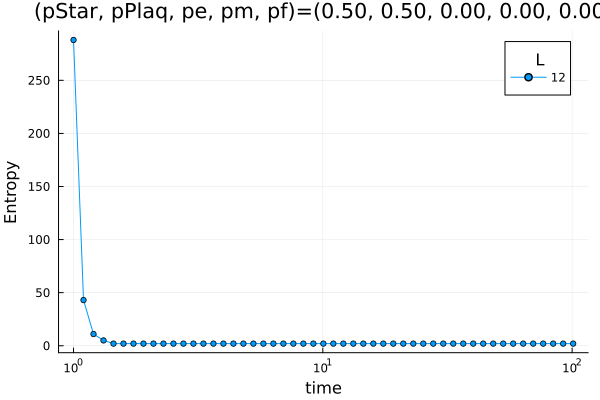

In [15]:
"""This is the main function that is called when the file is run from the terminal."""

# # get command line arguments and print them
# parsed_args = parse_commandline()

# p_TC = parsed_args["ptc"]
p_TC = 0.5
# pe = parsed_args["pe"]
pe = 0
# pm = parsed_args["pm"]
pm = 0
# L = parsed_args["L"]
L = 12
# nt = parsed_args["nt"]
nt = Int(1e2)
# outfname = parsed_args["outfile"]
# nmeasure = parsed_args["nmeasure"]
nmeasure = 51
# rngseed = parsed_args["rngseed"]

# # seed the random number generator
# Random.seed!(rngseed * big(2)^20)

pStar = p_TC  # measurement probabilities
pPlaq = p_TC
pe = 0.00
pm = 0.00
pf = 1 - 2 * p_TC - pe - pm


    

# Distribution of term types as given
# this just returns 1, 2, 3,4,5 with the give probabilities 
# init_dist = Categorical([0.5, 0.5, 0, 0, 0])
term_dist = Categorical([pStar, pPlaq, pe, pm, pf])


# times at which to measure stuff
measure_ts = exp10.(range(0, log10(nt+1), length=nmeasure))

# initial state is the maximally mixed state
# since the package does not let you create an empty tableau, I defined the identity as the stabilizer, which is the same statement
nbits = 2*L^2
maximally_mixed_state = Stabilizer(zeros(UInt8, 1), # phases
                                    zeros(Bool, 1, nbits), # Z Tableau (as matrix of bool)
                                    zeros(Bool, 1, nbits) # X Tableau
                                    );

    # this is running the initial dynamics, that is toric code measurements
state = MixedDestabilizer(maximally_mixed_state)
# entropy_t1 = run_measurement_only_dynamics!(state, # evolve this
#                                            () -> random_TC_condenser_Pauli(L, init_dist),  # bind 
#                                            100,
#                                            measure_ts)
# this is running the actual dynamics simulation
entropy_t2 = run_measurement_only_dynamics!(state, # evolve this
                                            () -> random_TC_condenser_Pauli(L, term_dist),  # bind 
                                            nt,
                                            measure_ts)

# println("(pStar, pPlaq, pe, pm, pf) : (", pStar, " ", pPlaq," ", pe, " ", pm, " ", pf, ")",
#         "\nL        : ", L,
#         "\nnt       : ", nt,
#         "\noutfile  : ", outfname,
#         "\nnmeasure : ", nmeasure,
#         "\nInitialEnt : ", entropy_t2[1],
#         "\nFinalEnt : ", last(entropy_t2))

# # create the parent directory for output file
# if !ispath(dirname(outfname))
#     mkpath(dirname(outfname))
# end

# # write output to hdf5
# h5open(outfname, "w") do outfile
#     write(outfile, "pStar", pStar)
#     write(outfile, "pPlaq", pPlaq)
#     write(outfile, "pe", pe)
#     write(outfile, "pm", pm)
#     write(outfile, "pf", pf)
#     write(outfile, "L", L)
#     write(outfile, "N", nbits)
#     write(outfile, "entropy", entropy_t2)
#     write(outfile, "time", measure_ts) 
# end


# plot entropy as function of time
p = plot(measure_ts, entropy_t2,
    title=format("(pStar, pPlaq, pe, pm, pf)=({:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f})", pStar, pPlaq, pe, pm, pf),
    xlabel="time",
    ylabel="Entropy",
    marker=(:circle, 3),
    xscale=:log10,
    # yscale=:log2,
    legendtitle="L",
    label=L)
# gui()  # this is the equivalent of matplotlibs show()
display(p)

In [18]:
entropy_t2'

1×51 adjoint(::Vector{Float64}) with eltype Float64:
 288.0  43.0  11.0  5.0  2.0  2.0  2.0  …  2.0  2.0  2.0  2.0  2.0  2.0  2.0